In [37]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Data_processing')
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, brier_score_loss, top_k_accuracy_score, balanced_accuracy_score, cohen_kappa_score, log_loss, PrecisionRecallDisplay, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
from data_processing import KOProcessor 
from scipy.stats import pearsonr
import warnings
from sklearn.calibration import calibration_curve
from itertools import cycle
from sklearn.exceptions import NotFittedError
from scipy.stats import entropy
sns.set_palette('crest')
warnings.filterwarnings('ignore')

In [38]:
# ADded changes for pipeline to run quicker, should equal 55 fits
 
param_grid = [
    {  
        'estimator': [MultiOutputClassifier(RandomForestClassifier(random_state=42))],
        'estimator__estimator__n_estimators': [100, 300],  # Reduced from [100, 200, 300]  
        'estimator__estimator__max_depth': [5, None]  # Reduced from [5, 10, 15, None]
    },
    {  
        'estimator': [MultiOutputClassifier(SVC(random_state=42, probability=True))],
        'estimator__estimator__C': [0.1, 1],  # Reduced from [0.1, 1, 10]
        'estimator__estimator__kernel': ['linear', 'rbf'], 
        'estimator__estimator__gamma': ['scale']  # Removed 'auto'
    },
    {
        'estimator': [MultiOutputClassifier(LogisticRegression())],
        'estimator__estimator__C': [0.1, 1, 10]  # Reduced from [0.01, 0.1, 1, 10, 100]
    }         
]

target_traits = ['substrate']  # Add/remove traits as needed

In [39]:
# Load and preprocess data
terms_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/terms_KO.zip'
terms_csv_path = 'terms_KO.csv'
traits_reduced_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/reducedDataset.zip'
traits_reduced_csv_path = 'reducedDataset.csv'
traits_assembled_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/assembledDataset.zip'
traits_assembled_csv_path = 'assembledDataset.csv'

processor = KOProcessor(
    terms_zip_path, 
    terms_csv_path, 
    traits_reduced_zip_path, 
    traits_reduced_csv_path, 
    traits_assembled_zip_path=traits_assembled_zip_path, 
    traits_assembled_csv_path=traits_assembled_csv_path
)

ko_terms = processor.load_terms()
if ko_terms is None:
    raise FileNotFoundError("KO terms could not be loaded. Please check the file paths.")

reduced_traits_data = processor.load_reduced_traits_data()
if reduced_traits_data is None:
    raise FileNotFoundError("Reduced traits data could not be loaded. Please check the file paths.")

# Preprocess KO terms
X_terms = processor.preprocess_terms(ko_terms)

# Preprocess all target traits into a DataFrame
y_dfs = []
label_encoders = {}  # Store encoders for each trait

for trait in target_traits:
    y_trait = processor.preprocess_traits(reduced_traits_data, trait_column=trait, use_assembled_if_missing=True)
    if y_trait is not None:
        # Encode labels to numerical values
        le = LabelEncoder()
        encoded = le.fit_transform(y_trait)
        y_dfs.append(pd.Series(encoded, index=y_trait.index, name=trait))
        label_encoders[trait] = le

y_combined = pd.concat(y_dfs, axis=1).dropna()

# Align features with labels
X_aligned, Y_aligned = processor.align_data(X_terms, y_combined)

# Feature Selection: Variance Threshold
selector = VarianceThreshold(threshold=0.02)
X_aligned = selector.fit_transform(X_aligned)

# Check trait distributions
for trait in target_traits:
    print(f"\nDistribution for {trait}:")
    print(Y_aligned[trait].value_counts())

Data loaded successfully:
   Unnamed: 0   key      KO
0           0  1000  K00001
1           1  1000  K13954
2           2  1000  K00003
3           3  1000  K00013
4           4  1000  K00014
Data loaded successfully:
   key  ...                                        ncbiFTP_FAA
0    1  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...
1    1  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...
2    2  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...
3    3  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...
4    4  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/9...

[5 rows x 18 columns]
Aggregated labels for 'substrate'. Unique keys: 3226

Distribution for substrate:
substrate
58     409
79     373
51     311
74     266
82     235
      ... 
88       1
90       1
163      1
22       1
48       1
Name: count, Length: 164, dtype: int64



Top |r| features for trait 'substrate':
Feature  Correlation      p_value
 K00228    -0.244499 4.013178e-45
 K00381    -0.243577 8.708635e-45
 K21420    -0.237316 1.543881e-42
 K07708    -0.231433 1.746096e-40
 K07712    -0.220401 8.720811e-37
 K09989    -0.220232 9.899216e-37
 K01894    -0.219042 2.411770e-36
 K02258    -0.216071 2.179869e-35
 K10804    -0.215559 3.174105e-35
 K15012    -0.214871 5.253066e-35


,Feature,Correlation,p_value,Trait
0,K00228,-0.244499,4.013178e-45,substrate
1,K00381,-0.243577,8.708635e-45,substrate
2,K21420,-0.237316,1.543881e-42,substrate
3,K07708,-0.231433,1.746096e-40,substrate
4,K07712,-0.220401,8.720811e-37,substrate
5,K09989,-0.220232,9.899216e-37,substrate
6,K01894,-0.219042,2.411770e-36,substrate
7,K02258,-0.216071,2.179869e-35,substrate
8,K10804,-0.215559,3.174105e-35,substrate
9,K15012,-0.214871,5.253066e-35,substrate


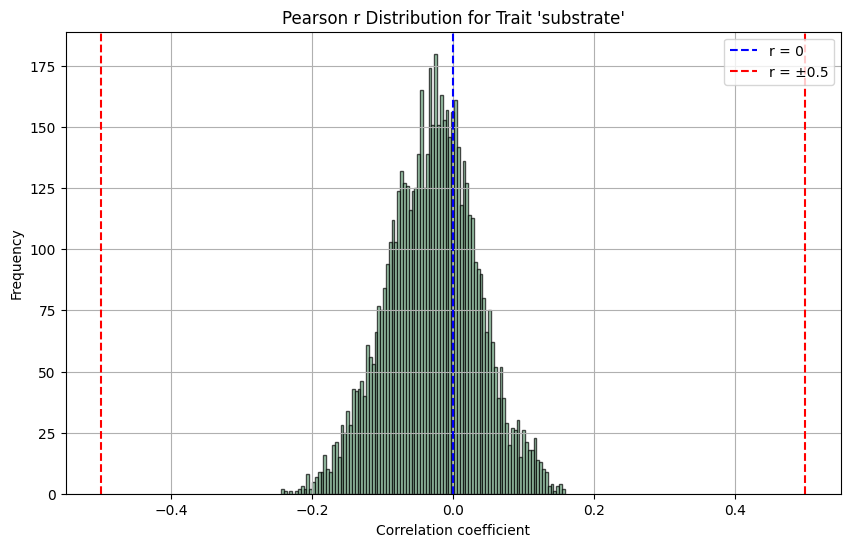

substrate label mapping:
  0 = (+)-d-galactose
  1 = (+)-d-glycogen
  2 = (+)-l-ornithine
  3 = (-)-d-fructose
  4 = (-)-quinic_acid
  5 = (2)-d-lactose
  6 = (r)-amygdalin
  7 = (r)-lactate
  8 = (r)-malic_acid
  9 = (r)-mandelate
  10 = (s)-lactate
  11 = (s)-mandelic_acid
  12 = 1,1,2,2-tetrachloroethane
  13 = 1,2-butandiol
  14 = 1,2-propandiol
  15 = 1,3-beta-d-glucan
  16 = 1-o-methyl_alpha-galactopyranoside
  17 = 1_%_sodium_lactate
  18 = 2,2-dimethylsuccinic_acid
  19 = 2,3-butanediol
  20 = 2-aminethanol
  21 = 2-aminobutyrate
  22 = 2-butanol
  23 = 2-dehydro-d-gluconate
  24 = 2-deoxy-d-ribose
  25 = 2-deoxyadenosine
  26 = 2-deoxythymidine-5'-4-nitrophenyl_phosphate
  27 = 2-hydroxybutyrate
  28 = 2-naphthyl_dihydrogen_phosphate
  29 = 2-oxobutanoate
  30 = 2-oxogluconate
  31 = 2-oxoglutarate
  32 = 2-oxopentanoate
  33 = 2-propanol
  34 = 3-hydroxybenzoate
  35 = 3-hydroxybutyrate
  36 = 3-nitropropanoate
  37 = 3-o-methyl-d-glucose
  38 = 3-o-methyl_alpha-d-glucopyrano

In [40]:
# 1) Grab the original X (with column names) back:
orig_X, _ = processor.align_data(X_terms, y_combined)

# 2) Get the boolean mask of features kept by VarianceThreshold:
mask = selector.get_support()

# 3) Extract those feature names:
feature_names = orig_X.columns[mask]

# 4) Rebuild a DataFrame so we can iterate .columns:
X_sel_df = pd.DataFrame(X_aligned, columns=feature_names)

# 5) Prepare a container for your per‐trait correlations:
#    { trait_name: DataFrame(Feature, Correlation, p_value) }
corr_results = {}

for trait in Y_aligned.columns:
    rs, ps = [], []
    y_vals = Y_aligned[trait].values.astype(float)   # already encoded ints
    for feat in X_sel_df.columns:
        r, p = pearsonr(X_sel_df[feat].values, y_vals)
        rs.append(r)
        ps.append(p)
    corr_results[trait] = pd.DataFrame({
        'Feature': feature_names,
        'Correlation': rs,
        'p_value': ps
    })

# 6) Now you can inspect or filter each trait’s correlations:
for trait, df in corr_results.items():
    print(f"\nTop |r| features for trait '{trait}':")
    display_df = df.assign(abs_r=df['Correlation'].abs()) \
                   .sort_values('abs_r', ascending=False) \
                   .drop(columns='abs_r') \
                   .head(10)
    print(display_df.to_string(index=False))

top_corr_df = pd.concat([
    df.assign(Trait=trait, abs_r=df['Correlation'].abs())
      .sort_values('abs_r', ascending=False)
      .drop(columns='abs_r')
      .head(10)
    for trait, df in corr_results.items()
], ignore_index=True)

# Now `top_corr_df` is ready for use in Data Wrangler or further analysis
display(top_corr_df)

for trait, df in corr_results.items():
    plt.figure(figsize=(10, 6))
    plt.hist(df['Correlation'], bins=100, edgecolor='black', alpha=0.7)
    plt.title(f"Pearson r Distribution for Trait '{trait}'")
    plt.axvline(0, color='blue', linestyle='--', label='r = 0')
    plt.axvline(0.5, color='red', linestyle='--', label='r = ±0.5')
    plt.axvline(-0.5, color='red', linestyle='--')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


for trait, encoder in label_encoders.items():
    print(f"{trait} label mapping:")
    for i, label in enumerate(encoder.classes_):
        print(f"  {i} = {label}")



In [41]:
#############################################
# Modified Functions for Multi-Output
#############################################

def plot_advanced_confusion_matrix(y_true, y_pred, classes, title):
    """Enhanced confusion matrix with normalization and counts"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='crest',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Normalized Confusion Matrix\n{title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add raw counts to bottom
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels([str(int(x)) for x in cm.sum(axis=0)])
    ax2.set_xlabel('Total Predictions')
    plt.show()

def plot_roc_curves(y_true, y_probs, classes, title):
    """Multiclass ROC curves with AUC scores"""
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all classes
    plt.figure(figsize=(10, 8))
    colors = cycle(sns.color_palette('crest', n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {title}')
    plt.legend(loc="lower right")
    plt.show()

def plot_class_probabilities(y_probs, classes, title):
    """Violin plot of class probability distributions"""
    prob_df = pd.DataFrame(y_probs, columns=classes)
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=prob_df, inner="quartile", palette="Set3")
    plt.title(f'Class Probability Distributions\n{title}')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.show()

def plot_feature_importance(feature_importances, feature_names, top_n=20, title=""):
    """Plot feature importance for tree-based models"""
    indices = np.argsort(feature_importances)[-top_n:]
    plt.figure(figsize=(10, 8))
    plt.title(f'Top {top_n} Feature Importances\n{title}')
    plt.barh(range(top_n), feature_importances[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

def plot_prediction_errors(y_true, y_pred, classes, title):
    """Error analysis: which classes are confused with others"""
    error_matrix = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(error_matrix, 0)  # Remove correct predictions
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(error_matrix, annot=True, fmt='d', cmap='crest',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Prediction Errors\n{title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def decode_labels(Y, label_encoders):
    """Convert numerical labels back to original text labels"""
    decoded = Y.copy()
    for trait in Y.columns:
        decoded[trait] = label_encoders[trait].inverse_transform(Y[trait])
    return decoded

# =============================================
#  Probability Trustworthiness Functions
# =============================================

def plot_calibration_curves(y_true, y_proba, classes, title):
    """Add this after existing plotting functions"""
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(classes):
        true_binary = (y_true == i).astype(int)
        prob_pos = y_proba[:, i]
        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_binary, prob_pos, n_bins=10, strategy='quantile'
        )
        plt.plot(mean_predicted_value, fraction_of_positives, 's-', 
                label=f'{class_name}')

    plt.plot([0, 1], [0, 1], 'k:', label='Perfect')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positive Samples')
    plt.title(f'Calibration: {title}')
    plt.legend(loc='lower right')
    plt.show()

def calculate_brier_scores(y_true, y_proba, classes):
    """Add this with other metric functions"""
    scores = {}
    for i, class_name in enumerate(classes):
        true_binary = (y_true == i).astype(int)
        scores[class_name] = brier_score_loss(true_binary, y_proba[:, i])
    return pd.DataFrame.from_dict(scores, orient='index', columns=['Brier Score'])

def analyze_prediction_entropy(y_proba, classes):
    """Enhanced with uncertainty samples identification"""
    entropies = np.array([entropy(probs) for probs in y_proba])
    
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(entropies, bins=30, kde=True)
    
    # Add uncertainty thresholds
    low_uncertainty = np.log(len(classes)) * 0.3
    high_uncertainty = np.log(len(classes)) * 0.7
    ax.axvline(x=low_uncertainty, color='g', linestyle='--', label='Low uncertainty')
    ax.axvline(x=high_uncertainty, color='r', linestyle='--', label='High uncertainty')
    
    plt.title('Prediction Entropy Distribution')
    plt.xlabel('Entropy (Higher = More Uncertainty)')
    plt.legend()
    plt.show()
    
    # Return indices of uncertain samples
    return np.where(entropies > high_uncertainty)[0]

def check_probability_consistency(y_proba, y_pred, classes):
    """Verify predicted class matches highest probability"""
    mismatches = 0
    for i in range(len(y_pred)):
        if not np.isclose(y_proba[i, y_pred[i]], np.max(y_proba[i])):
            mismatches += 1
    print(f"\nProbability consistency: {100*(1-mismatches/len(y_pred)):.2f}% match")

def validate_probabilities(y_proba, y_pred):
    """Check probability validity with tolerance"""
    # Check probability sums
    if not np.allclose(y_proba.sum(axis=1), 1.0, atol=0.01):
        print("Warning: Probabilities don't sum to 1 ±0.01")
    
    # Check prediction consistency
    mismatch_mask = y_pred != np.argmax(y_proba, axis=1)
    mismatch_rate = np.mean(mismatch_mask)
    
    if mismatch_rate > 0:
        print(f"Warning: {mismatch_rate:.2%} predictions don't match max probabilities")
        print("Sample mismatches:")
        for i in np.where(mismatch_mask)[0][:3]:  # Show first 3
            print(f"Sample {i}: Predicted {y_pred[i]}, Max prob at {np.argmax(y_proba[i])}")

def plot_confidence_distribution(y_proba, title):
    """Distribution of maximum class probabilities"""
    max_probs = np.max(y_proba, axis=1)
    plt.figure(figsize=(10, 5))
    sns.histplot(max_probs, bins=20, kde=True)
    plt.title(f'Prediction Confidence: {title}')
    plt.xlabel('Maximum Class Probability')
    plt.show()

def find_ambiguous_samples(y_proba, threshold=0.1):
    """Identify samples where top-2 classes are close"""
    sorted_probs = np.sort(y_proba, axis=1)
    return np.where(sorted_probs[:, -1] - sorted_probs[:, -2] < threshold)[0]

def plot_metric_comparison(y_true, y_pred, y_proba, classes):
    """Comparative bar plot of key metrics"""
    metrics = {
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
        'Log Loss': log_loss(LabelEncoder().fit_transform(y_true), y_proba)
    }
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    plt.title('Classifier Performance Metrics')
    plt.ylim(0, 1)
    plt.ylabel('Score')
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
    plt.show()

# =============================================
# Per-Class Evaluation Functions
# =============================================
def plot_class_confusion_matrix(y_true, y_pred, class_name, class_idx):
    """Confusion matrix focused on one class"""
    binary_true = (y_true == class_idx)
    binary_pred = (y_pred == class_idx)
    
    cm = confusion_matrix(binary_true, binary_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
                xticklabels=['Other', class_name],
                yticklabels=['Other', class_name])
    plt.title(f'Class Focus: {class_name}')
    plt.show()


def plot_class_precision_recall(y_true, y_proba, class_idx, class_name):
    """Precision-Recall curve for individual classes"""
    binary_true = (y_true == class_idx)
    PrecisionRecallDisplay.from_predictions(binary_true, y_proba[:, class_idx])
    plt.title(f'Precision-Recall: {class_name}')
    plt.show()


def plot_class_feature_importance(importances, feature_names, class_name):
    """Feature importance for a specific class"""
    indices = np.argsort(importances)[-20:]
    plt.figure(figsize=(10,6))
    plt.barh(range(20), importances[indices], align='center')
    plt.yticks(range(20), feature_names[indices])
    plt.title(f'Top Features for {class_name}')
    plt.xlabel('Importance')
    plt.show()

def plot_spider(metrics, title, palette_color=None):
    """Radar chart of performance metrics using crest palette"""
    categories = ['F1‑score','Accuracy','Specificity','Sensitivity','Precision', 'MCC']
    N = len(categories)
    
    values = [metrics[c] for c in categories]
    values += values[:1]
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'polar': True}, facecolor='white')
    
    # Use crest palette
    color = sns.color_palette("crest", n_colors=1)[0] if palette_color is None else palette_color
    
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, color='grey', size=10)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], color="grey", size=8)
    plt.ylim(0,1)
    plt.title(title, size=12, y=1.1)
    plt.show()

def plot_f1_mcc_comparison(f1_scores, mcc_scores, classes):
    """F1 vs MCC comparison with crest colors"""
    plt.figure(figsize=(10,6))
    plot = sns.scatterplot(x=f1_scores, y=mcc_scores, hue=classes,
                           palette='crest', s=100, edgecolor='w')
    plt.plot([0,1], [0,1], 'k--', alpha=0.3)
    plt.title('F1 vs MCC Score Comparison (Per Class)')
    plt.xlabel('F1 Score')
    plt.ylabel('MCC Score')
    plt.grid(True)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# =============================================
#  Model training and evaluation
# =============================================

def train_and_evaluate_multitrait(X_aligned, Y_aligned, target_traits, label_encoders, feature_names):
    # Split data
    print(f"\nStarting evaluation for traits: {target_traits}")
    print(f"Total samples: {len(X_aligned)}, Features: {len(feature_names)}")
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_aligned, Y_aligned, test_size=0.2, random_state=42, stratify=Y_aligned)
    
    # Pipeline
    pipeline = Pipeline([
        ('estimator', MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    # Grid Search
    grid_search = GridSearchCV(pipeline, param_grid, cv=4, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train)
    
    # After model training:
    best_model = grid_search.best_estimator_
    print("\nCross-validation results:")
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print(cv_results[['param_estimator', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))
    print("\nBest model parameters:")
    print(grid_search.best_params_)
    
    # Get predictions and probabilities
    Y_pred_test = best_model.predict(X_test)
    Y_proba_test = best_model.predict_proba(X_test)

    # Early probability check
    print("\nSample raw probability outputs:")
    for i, trait in enumerate(target_traits):
        print(f"\nFirst 5 samples - {trait}:")
        print(pd.DataFrame(Y_proba_test[i][:5], columns=label_encoders[trait].classes_))
    
    # Decode labels
    Y_test_decoded = decode_labels(pd.DataFrame(Y_test, columns=target_traits), label_encoders)
    Y_pred_decoded = decode_labels(pd.DataFrame(Y_pred_test, columns=target_traits), label_encoders)
    
    # Per-trait evaluation
    for idx, trait in enumerate(target_traits):
        classes = label_encoders[trait].classes_
        n_classes = len(classes)
        y_true = Y_test_decoded[trait]
        y_pred = Y_pred_decoded[trait]
        y_proba = Y_proba_test[idx]
        y_true_encoded = label_encoders[trait].transform(y_true)
        
        print(f"\n{'='*40}\nEvaluation for {trait}\n{'='*40}")
        print(f"Expected classes: {list(classes)}")
        
        # Validate probabilities first
        validate_probabilities(y_proba, Y_pred_test[:, idx])
        
        # Core metrics comparison
        plot_metric_comparison(y_true, y_pred, y_proba, classes)

        # Calculate specificity
        cm = confusion_matrix(y_true_encoded, Y_pred_test[:, idx])
        specificity_scores = []
        for i in range(len(cm)):
            tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
            fp = cm[:,i].sum() - cm[i,i]
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            specificity_scores.append(specificity)
        
        metrics = {
            'F1‑score': f1_score(y_true_encoded, Y_pred_test[:, idx], average='macro'),
            'Accuracy': accuracy_score(y_true_encoded, Y_pred_test[:, idx]),
            'Specificity': np.mean(specificity_scores),
            'Sensitivity': recall_score(y_true_encoded, Y_pred_test[:, idx], average='macro'),
            'Precision': precision_score(y_true_encoded, Y_pred_test[:, idx], average='macro'),
            'MCC': matthews_corrcoef(y_true_encoded, Y_pred_test[:, idx])
        }
        
        # Generate spider plot
        #plot_spider(metrics, f"Performance Radar - {trait}", palette_color=sns.color_palette("crest")[2])
        
        # Generate F1 vs MCC comparison
        '''class_f1 = f1_score(y_true_encoded, Y_pred_test[:, idx], average=None)
        class_mcc = []
        for class_idx in range(len(classes)):
            y_true_bin = (y_true_encoded == class_idx).astype(int)
            y_pred_bin = (Y_pred_test[:, idx] == class_idx).astype(int)
            class_mcc.append(matthews_corrcoef(y_true_bin, y_pred_bin))
        
        plot_f1_mcc_comparison(class_f1, class_mcc, classes)'''
        
        # 1. Classification Report (forced to include all classes)
        print("\nClassification Report (all classes):")
        print(classification_report(
            y_true,
            y_pred,
            target_names=classes,
            labels=np.arange(n_classes),
            zero_division=0
        ))

        # 2. Classification Report (only present classes)
        print("\nClassification Report (present classes only):")
        print(classification_report(y_true, y_pred))
        
        # 3. Confidence Analysis
        plot_confidence_distribution(y_proba, trait)
        print(f"Mean confidence: {np.max(y_proba, axis=1).mean():.2%}")
        
        # 4. Top-2 Accuracy
        if len(classes) > 2:
            try:
                top2_acc = top_k_accuracy_score(y_true_encoded, y_proba, k=2)
                print(f"Top-2 Accuracy: {top2_acc:.2%}")
            except Exception as e:
                print(f"Could not compute top-2 accuracy: {str(e)}")
                
        # 5. Ambiguous Samples
        ambiguous_idx = find_ambiguous_samples(y_proba)
        print(f"Found {len(ambiguous_idx)} ambiguous samples (Δprob < 0.1)")
        
        # 6. Advanced Confusion Matrix
        plot_advanced_confusion_matrix(y_true, y_pred, classes, trait)
        
        # 7. ROC Curves (One-vs-Rest)
        plot_roc_curves(y_true_encoded, y_proba, classes, trait)
        
        # 8. Class Probability Distributions
        plot_class_probabilities(y_proba, classes, trait)
        
        # 9. Prediction Error Analysis
        plot_prediction_errors(y_true, y_pred, classes, trait)
        
        # 10. Calibration Curves
        plot_calibration_curves(y_true_encoded, y_proba, classes, trait)
        
        # 11. Brier Scores
        brier_scores = calculate_brier_scores(y_true_encoded, y_proba, classes)
        print("Brier Scores (Lower = Better):")
        print(brier_scores)
        
        # 12. Entropy Analysis
        uncertain_samples = analyze_prediction_entropy(y_proba, classes)
        print(f"Found {len(uncertain_samples)} highly uncertain predictions")
        
        
        # 13. Feature Importance (for supported estimators)
        '''try:
            # Get the fitted estimator from the multi-output wrapper
            fitted_estimator = best_model.named_steps['estimator'].estimators_[idx]
            
            if hasattr(fitted_estimator, 'feature_importances_'):
                importances = fitted_estimator.feature_importances_
                plot_feature_importance(importances, feature_names, title=trait)
            else:
                print(f"\nFeature importance not available for {type(fitted_estimator).__name__}")
        except (AttributeError, NotFittedError) as e:
            print(f"\nCould not compute feature importance for {trait}: {str(e)}")
        except Exception as e:
            print(f"\nUnexpected error computing feature importance: {str(e)}")
        
        # 14. Per-label confusion matrix, precision-recall, and feature importance
        for class_idx, class_name in enumerate(classes):
            # Class-specific confusion matrix
            plot_class_confusion_matrix(y_true_encoded, Y_pred_test[:, idx], class_name, class_idx)
            
            # Precision-Recall curve
            plot_class_precision_recall(y_true_encoded, y_proba, class_idx, class_name)
            
            # Class-specific feature importance (if using RandomForest)
            if 'randomforest' in str(best_model.named_steps['estimator'].estimator).lower():
                importances = best_model.named_steps['estimator'].estimators_[idx].feature_importances_
                plot_class_feature_importance(importances, feature_names, class_name)'''

        
        print(f"\nCompleted evaluation for {trait}")
    
    # Return the best model after all traits and classes are processed
    print("\nEvaluation complete for all traits")
    return best_model


Starting evaluation for traits: ['oxygen']
Total samples: 3256, Features: 6193
Fitting 4 folds for each of 11 candidates, totalling 44 fits

Cross-validation results:
                                      param_estimator  ...  std_test_score
3   MultiOutputClassifier(estimator=RandomForestCl...  ...        0.001274
2   MultiOutputClassifier(estimator=RandomForestCl...  ...        0.006084
7   MultiOutputClassifier(estimator=SVC(probabilit...  ...        0.009312
8   MultiOutputClassifier(estimator=LogisticRegres...  ...        0.004207
9   MultiOutputClassifier(estimator=LogisticRegres...  ...        0.004918
10  MultiOutputClassifier(estimator=LogisticRegres...  ...        0.007397
4   MultiOutputClassifier(estimator=SVC(probabilit...  ...        0.005683
6   MultiOutputClassifier(estimator=SVC(probabilit...  ...        0.005683
1   MultiOutputClassifier(estimator=RandomForestCl...  ...        0.009866
0   MultiOutputClassifier(estimator=RandomForestCl...  ...        0.008990
5   Mul

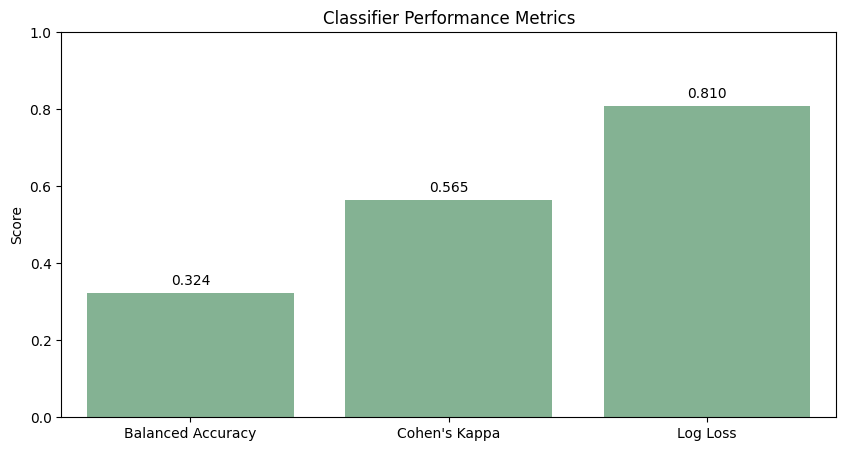

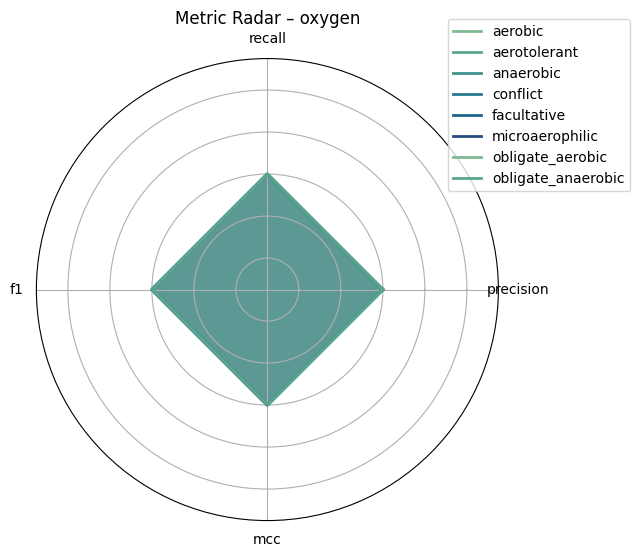

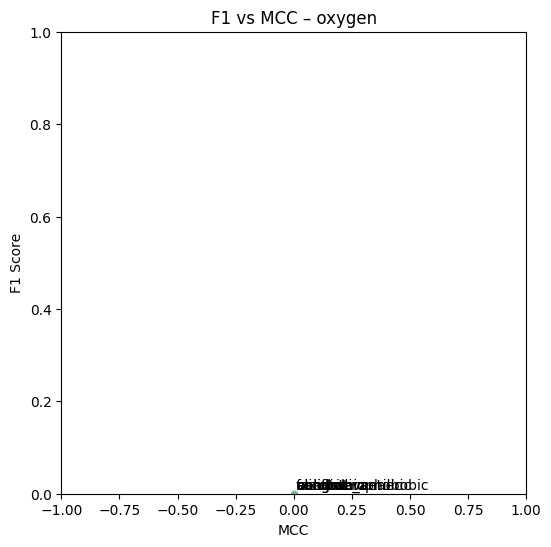


Classification Report (all classes):
                    precision    recall  f1-score   support

           aerobic       0.00      0.00      0.00         0
      aerotolerant       0.00      0.00      0.00         0
         anaerobic       0.00      0.00      0.00         0
          conflict       0.00      0.00      0.00         0
       facultative       0.00      0.00      0.00         0
   microaerophilic       0.00      0.00      0.00         0
  obligate_aerobic       0.00      0.00      0.00         0
obligate_anaerobic       0.00      0.00      0.00         0

         micro avg       0.00      0.00      0.00         0
         macro avg       0.00      0.00      0.00         0
      weighted avg       0.00      0.00      0.00         0


Classification Report (present classes only):
                    precision    recall  f1-score   support

           aerobic       0.78      0.98      0.87       377
      aerotolerant       0.00      0.00      0.00         1
         an

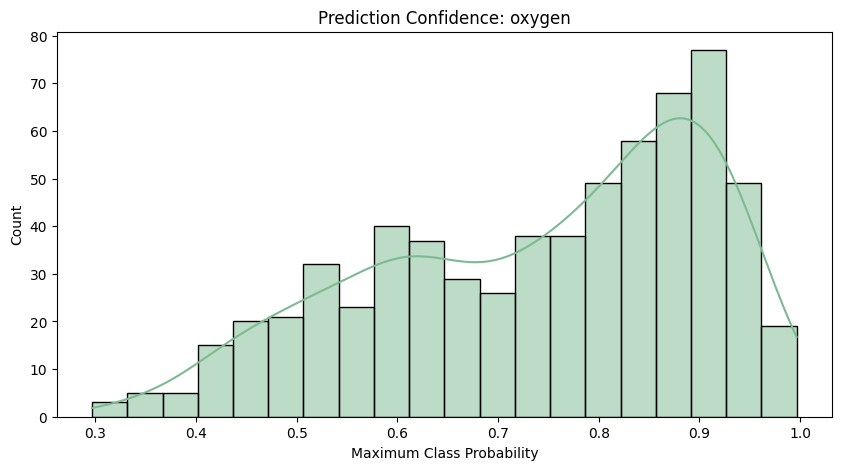

Mean confidence: 74.19%
Top-2 Accuracy: 91.41%
Found 34 ambiguous samples (Δprob < 0.1)


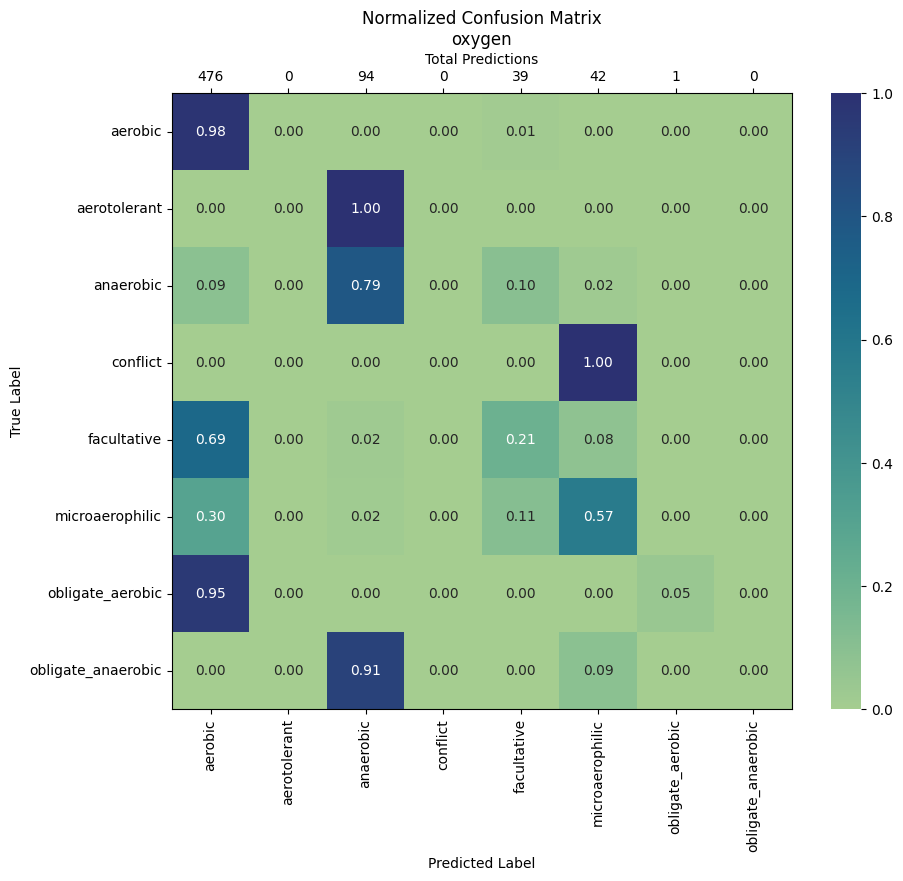

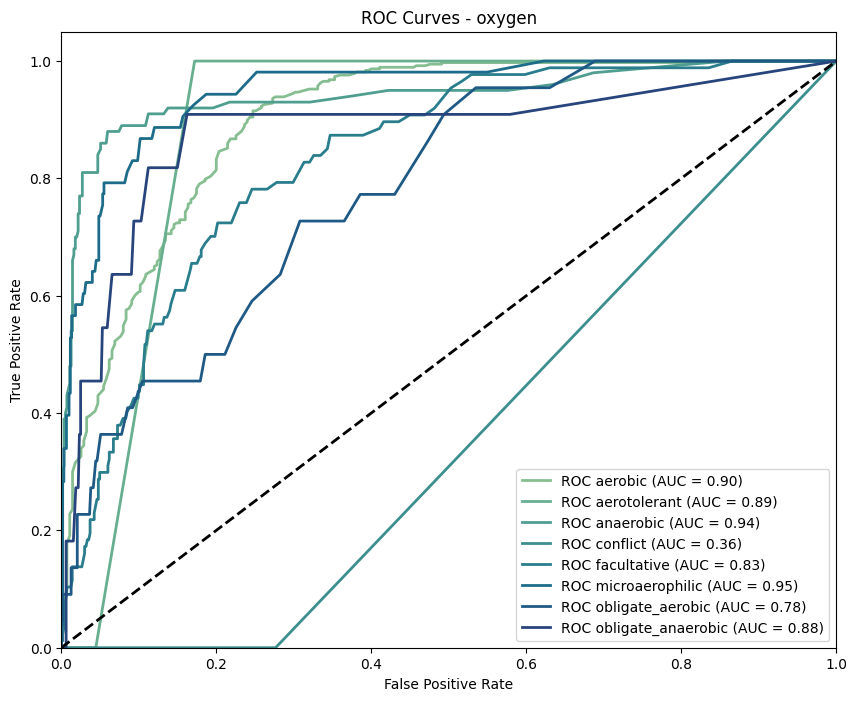

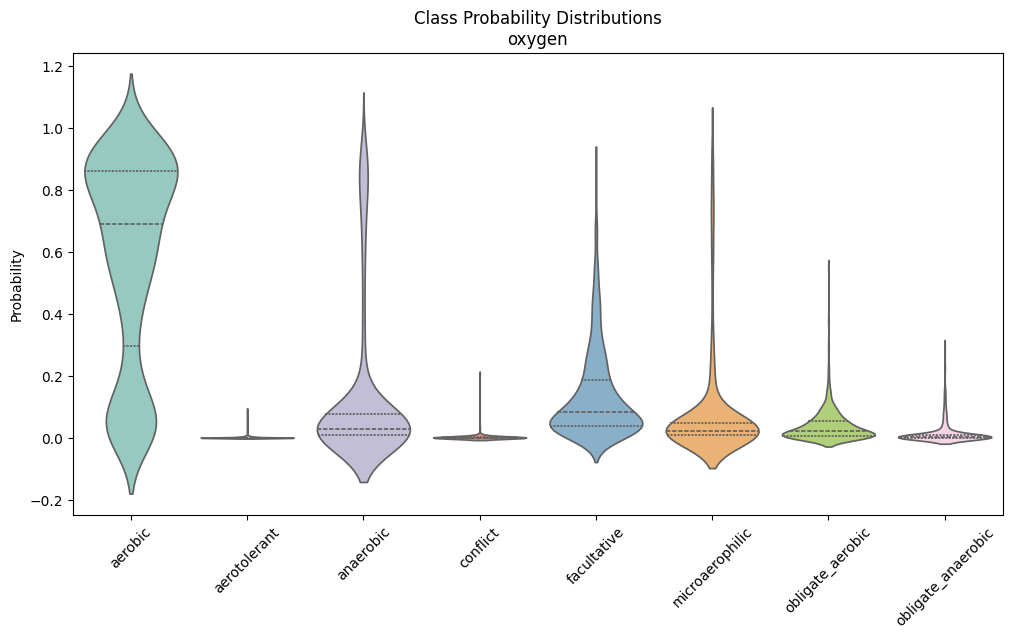

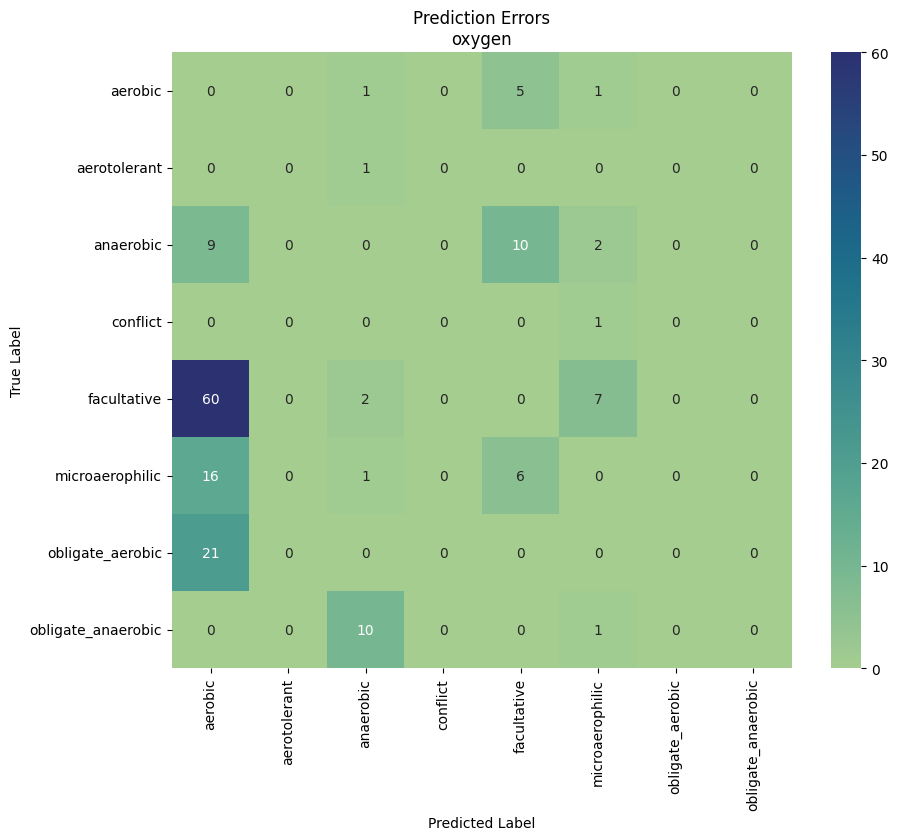

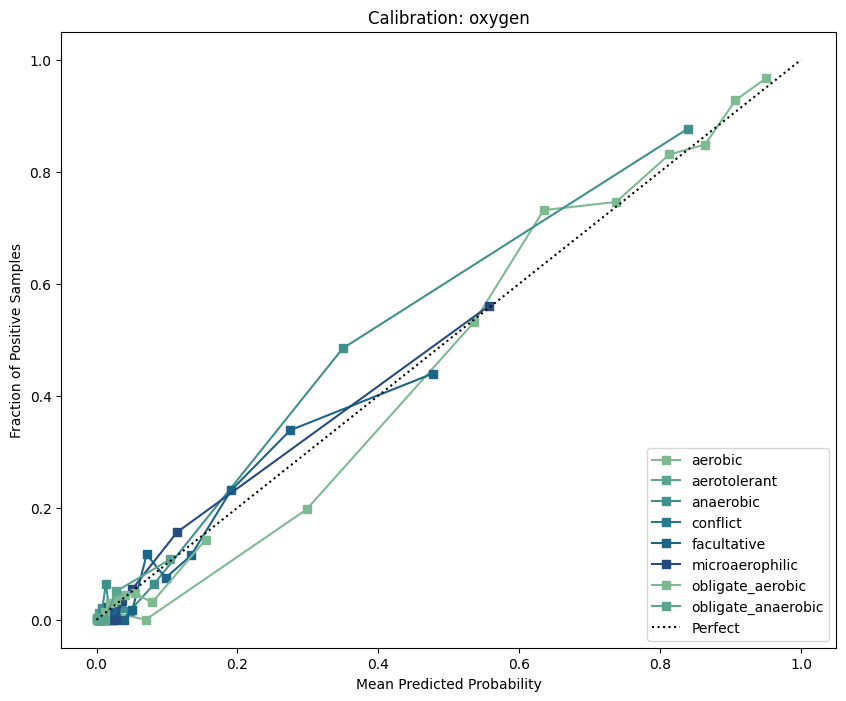

Brier Scores (Lower = Better):
                    Brier Score
aerobic                0.118336
aerotolerant           0.001545
anaerobic              0.048395
conflict               0.001724
facultative            0.094650
microaerophilic        0.040260
obligate_aerobic       0.030376
obligate_anaerobic     0.015255


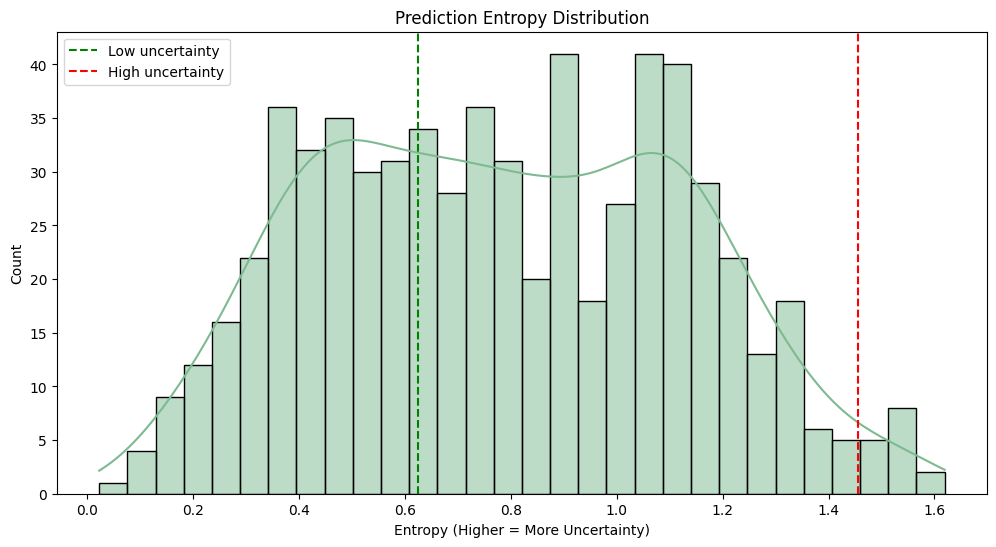

Found 15 highly uncertain predictions


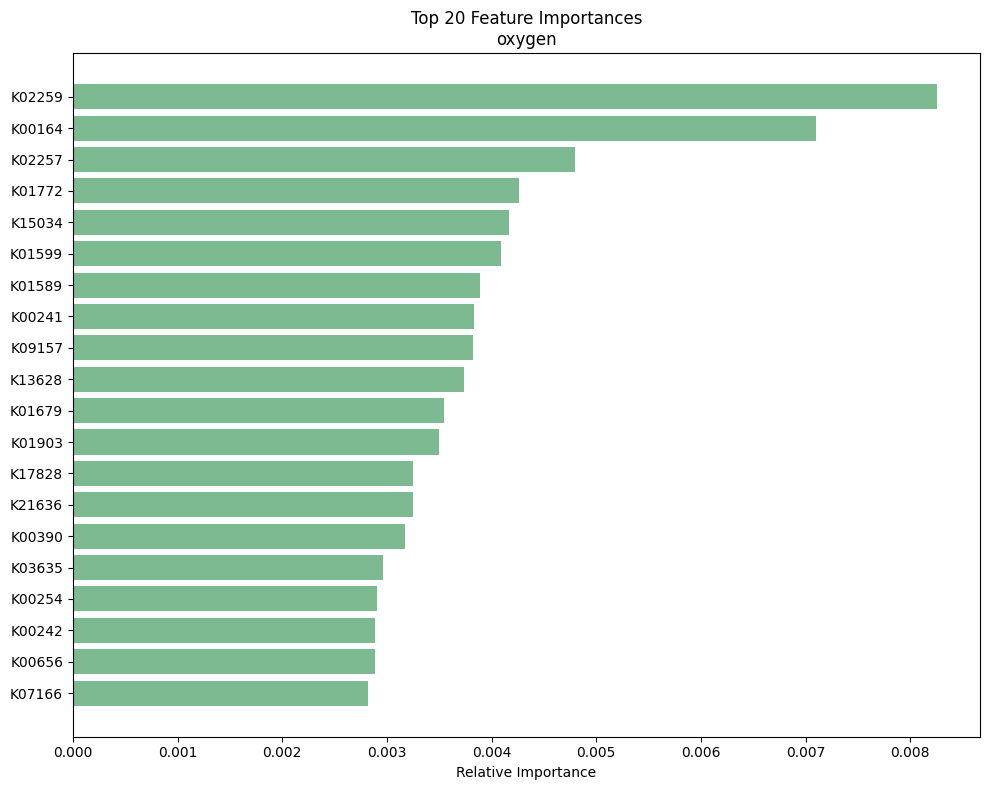

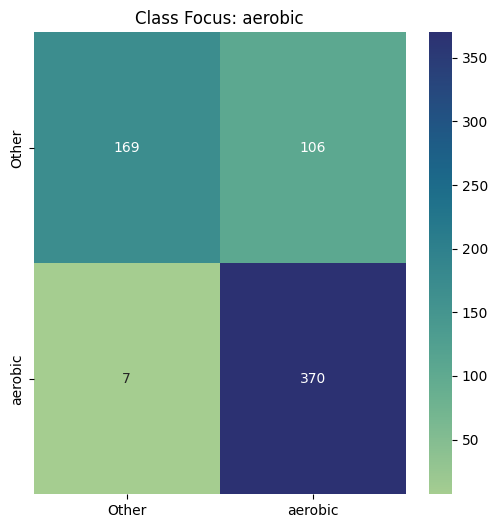

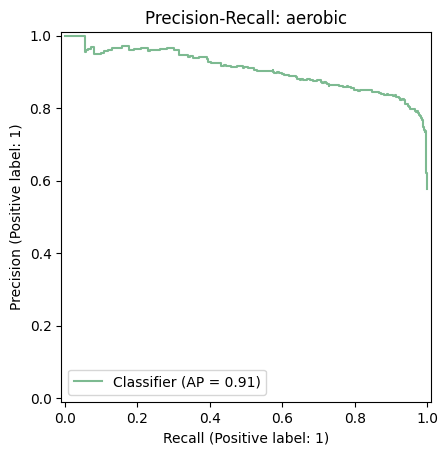

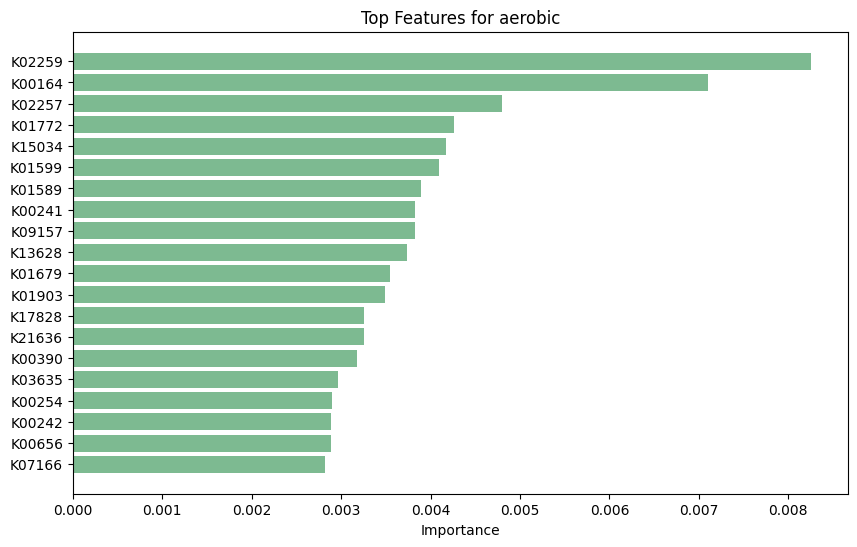

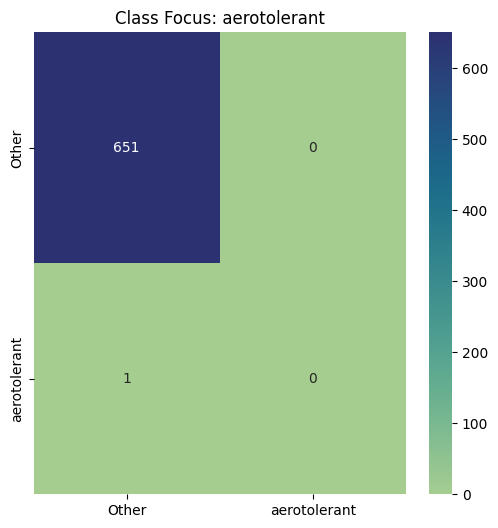

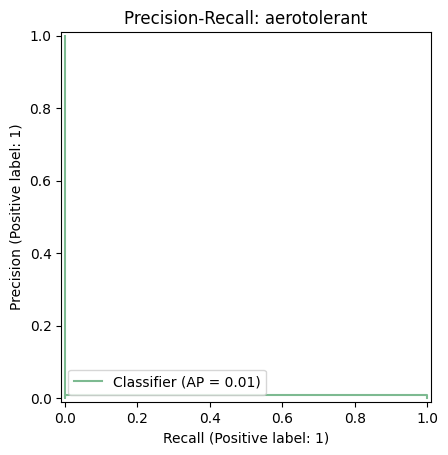

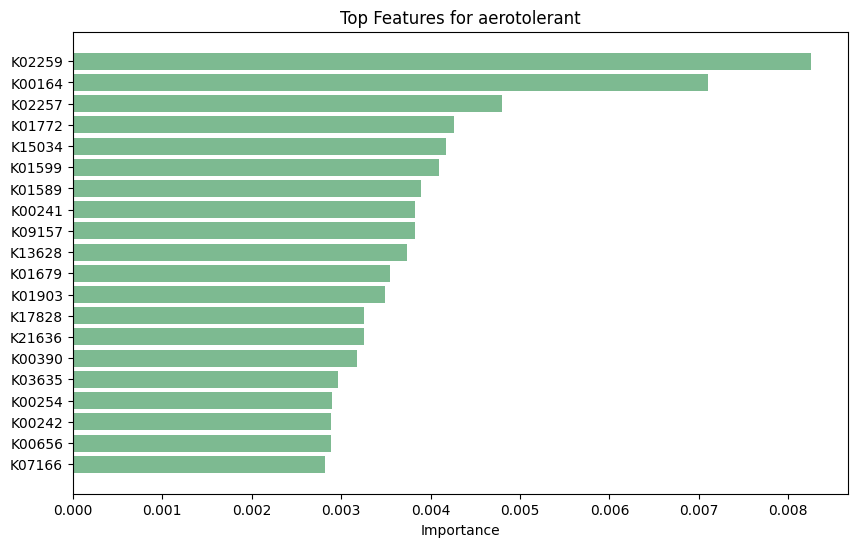

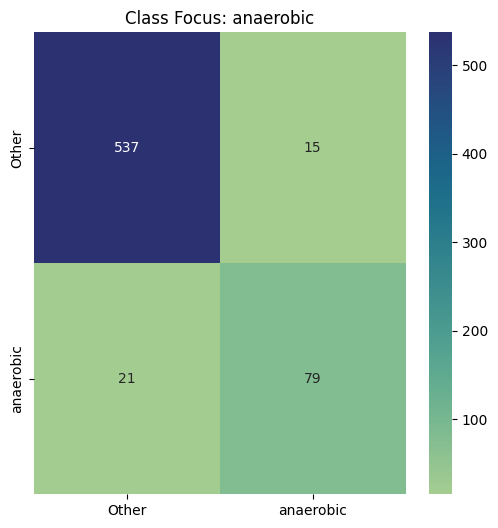

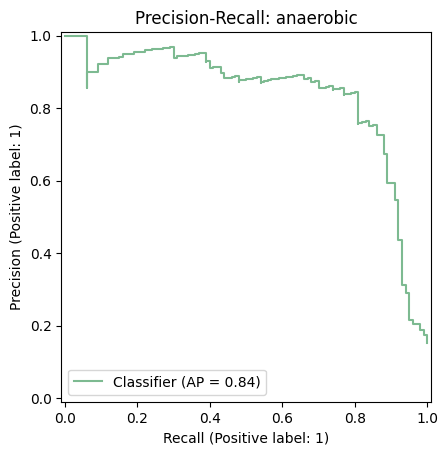

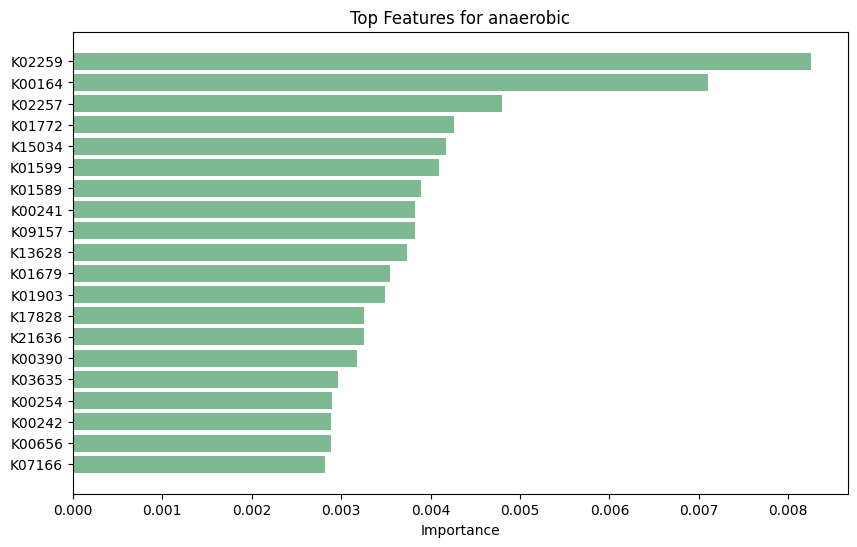

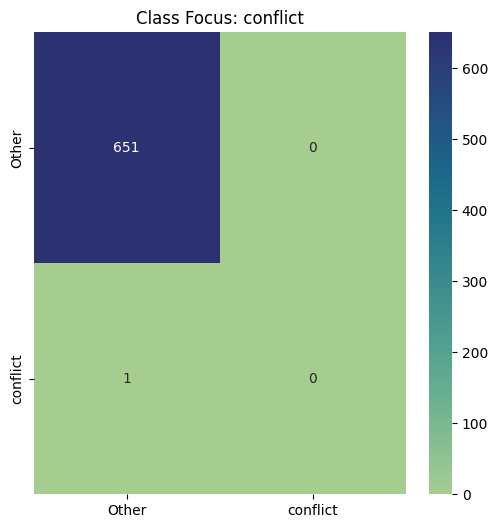

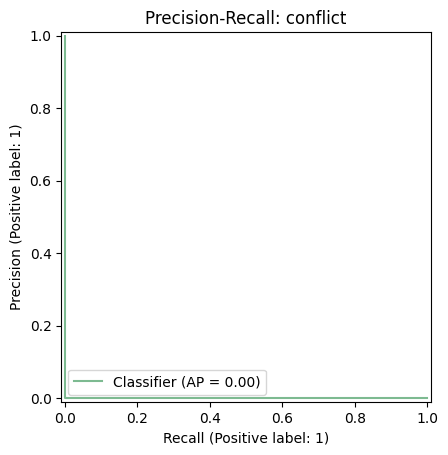

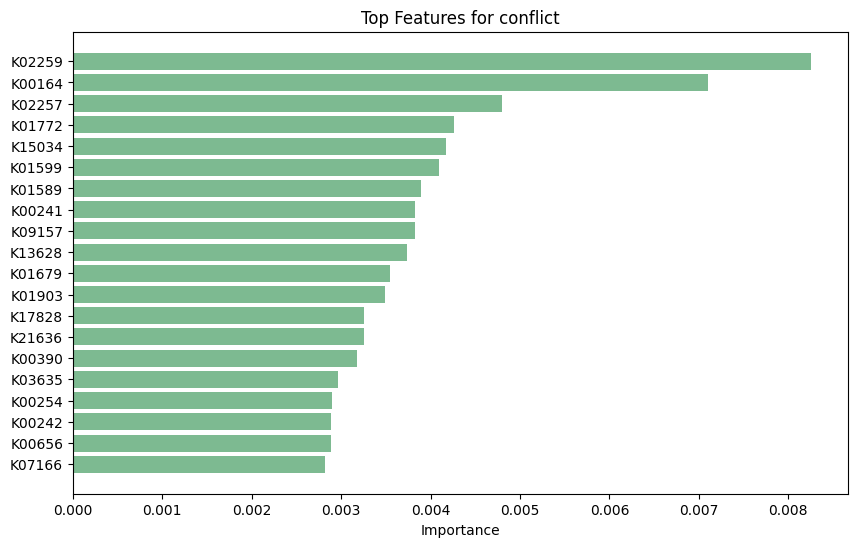

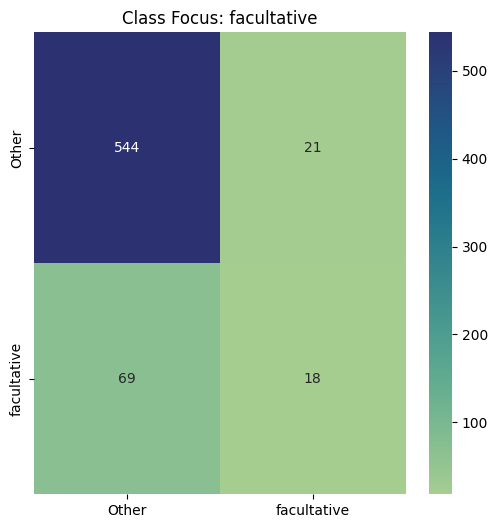

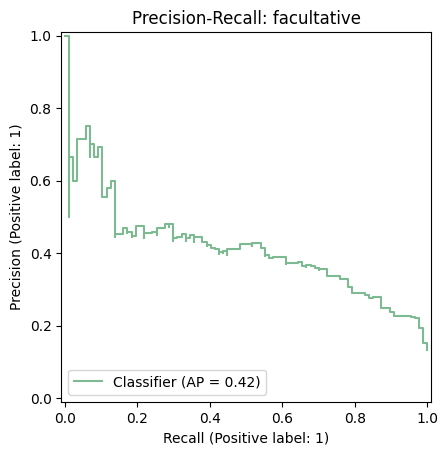

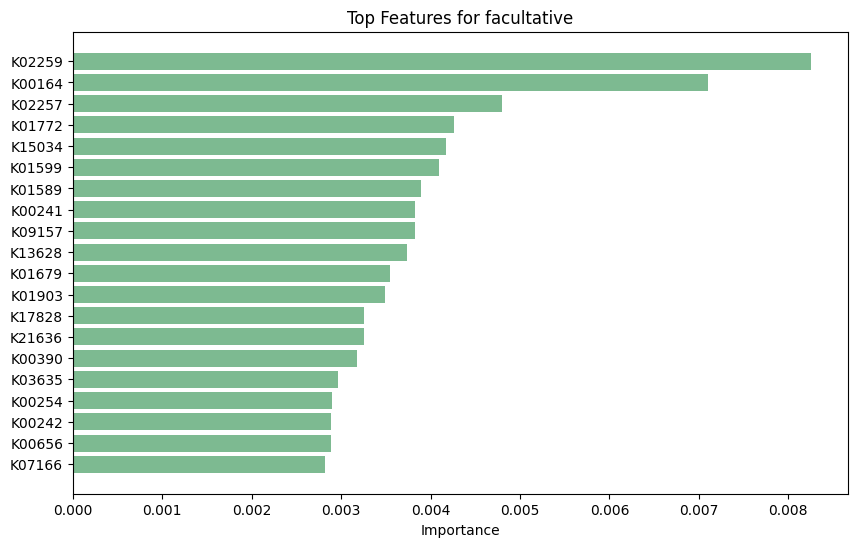

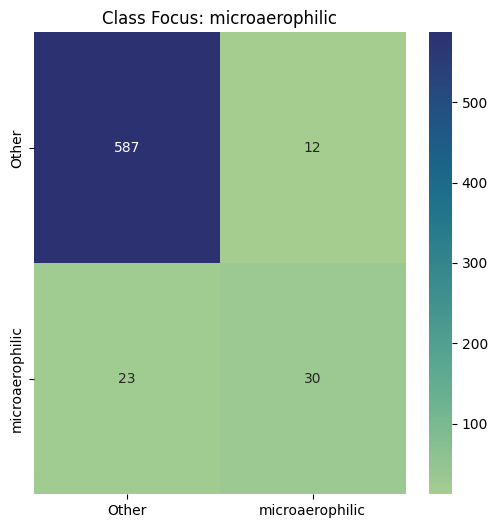

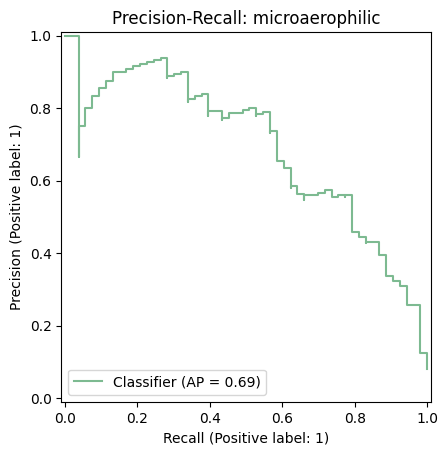

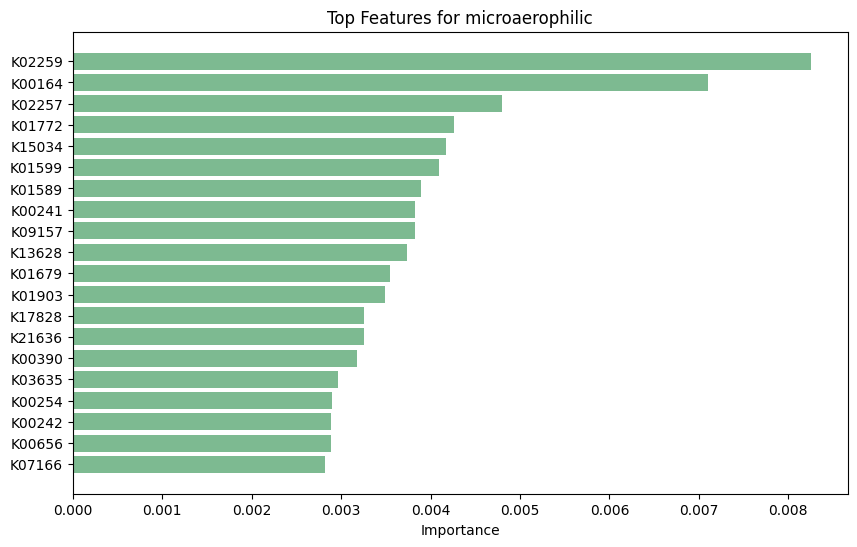

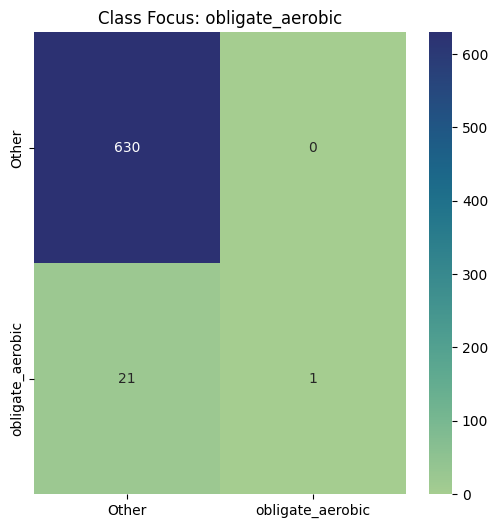

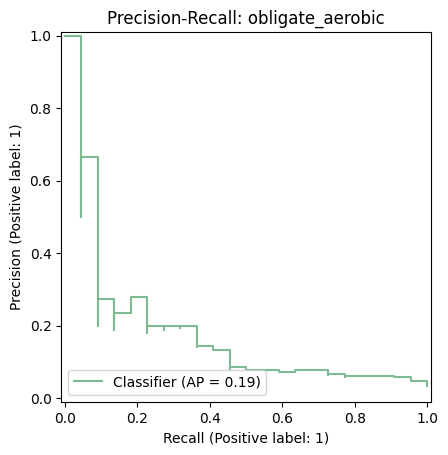

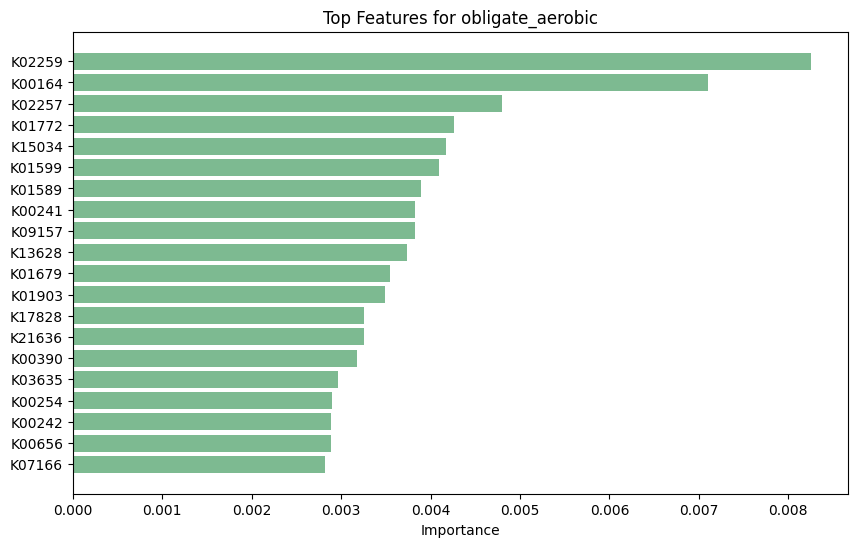

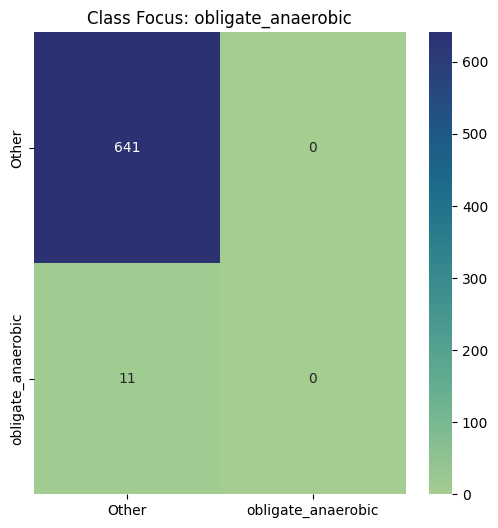

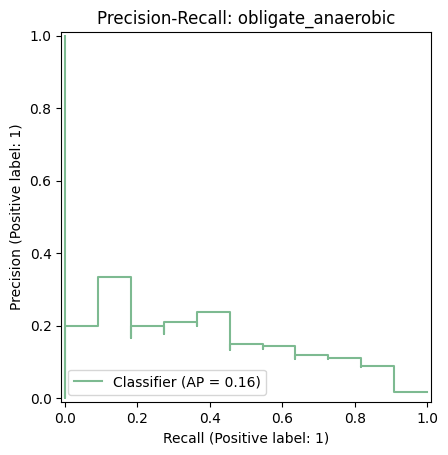

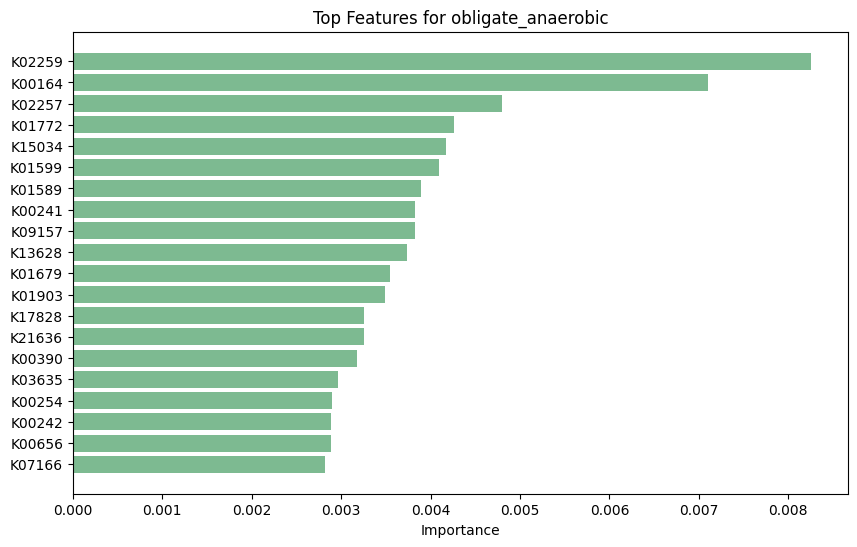

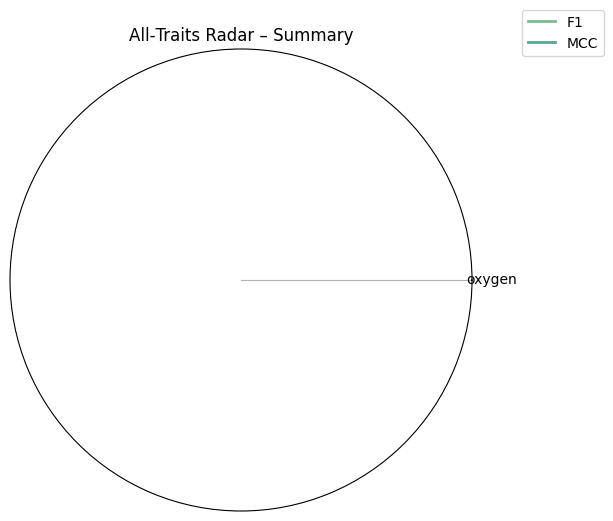


Completed evaluation for oxygen

Evaluation complete for all traits


In [7]:
# Run the multiclass classification pipeline 
Results_model = train_and_evaluate_multitrait(
    X_aligned, 
    Y_aligned, 
    target_traits, 
    label_encoders,
    feature_names=selector.get_feature_names_out()  # From variance threshold
)

# Thoughts regarding the classification 

## 1. Advanced Confusion Matrix
**What it shows**:  
- Normalized prediction accuracy per class (rows sum to 1)  
- Raw prediction counts in bottom axis  

**Example**:  
For oxygen tolerance prediction:  
- 95% of true aerobes correctly predicted (row 1)  
- 10% of anaerobes misclassified as facultative (row 2, column 3)  

**Biological significance**:  
Identifies which microbial classes are frequently confused (e.g., facultative vs. microaerophilic)

---

## 2. ROC Curves & AUC Scores
**What it shows**:  
- True Positive Rate vs False Positive Rate for each class  
- AUC = Area Under Curve (1.0 = perfect, 0.5 = random)  

**Example**:  
Facultative class AUC=0.92 vs Anaerobic AUC=0.85 suggests better distinction of facultative organisms  

**Biological significance**:  
Measures how well KO terms separate different metabolic strategies

---

## 3. Class Probability Distributions
**What it shows**:  
- Distribution of predicted probabilities for each class  

**Example**:  
Narrow peak at 1.0 for "Gram-positive" shows high confidence  
Wide distribution for "Photolithotroph" indicates uncertainty  

**Biological significance**:  
Reveals ambiguous cases that might represent transitional phenotypes

---

## 4. Feature Importance
**What it shows**:  
- Top N most important KO terms for predictions  

**Example**:  
KO00010 (glycolysis) important for facultative prediction  

**Biological significance**:  
Identifies key metabolic pathways associated with specific traits

---

## 5. Prediction Error Analysis
**What it shows**:  
- Confusion between classes after removing correct predictions  

**Example**:  
Strong anaerobe↔facultative confusion suggests overlapping metabolic capabilities  

**Biological significance**:  
Highlights evolutionarily related traits that are hard to distinguish

---

## 6. Calibration Curves
**What it shows**:  
- Alignment of predicted probabilities with actual frequencies  

**Example**:  
At 0.8 predicted probability, 75% are actually positive  

**Biological significance**:  
Indicates whether probabilities can be trusted for rare phenotypes

---

## 7. Brier Scores
**What it shows**:  
- Mean squared error of probabilities (0=perfect, 1=worst)  

**Example**:  
Brier=0.12 for aerobes vs 0.25 for microaerophiles  

**Biological significance**:  
Identifies traits where genomic signatures are less distinct

---

## 8. Prediction Entropy
**What it shows**:  
- Uncertainty distribution across predictions  
- Thresholds: Low (<30% max), High (>70% max)  

**Example**:  
High entropy samples often match uncharacterized genomes  

**Biological significance**:  
Flags samples needing additional experimental validation

---

## 9. Confidence Distribution
**What it shows**:  
- Distribution of maximum class probabilities  

**Example**:  
Peak at 0.6-0.8 suggests conservative predictions  

**Biological significance**:  
Indicates overall model confidence in genome annotations

---

## 10. Ambiguous Samples
**What it shows**:  
- Samples where top-2 class probabilities differ by <0.1  

**Example**:  
Genome with 48% aerobic vs 45% facultative prediction  

**Biological significance**:  
Identifies potentially novel or transitional phenotypes

---

## 11. Metric Comparison
**What it shows**:  
- Balanced Accuracy: Performance on imbalanced classes  
- Cohen's Kappa: Agreement beyond chance  
- Log Loss: Probability calibration quality  

**Example**:  
High Kappa (>0.8) but moderate Log Loss (0.4) indicates good predictions with overconfident probabilities  

**Biological significance**:  
Holistic performance assessment for trait prediction reliability

# Key Questions to Answer:
### Are probabilities calibrated?
→ Check calibration curves & Brier scores

### Where is the model uncertain?
→ Entropy analysis + probability distributions

### Do errors make biological sense?
→ Confusion matrices between similar traits (e.g., facultative vs. microaerophilic)

### Can we trust high-confidence predictions?
→ Reliability diagrams for high-probability bins (>80%)


Interpretation:
- Excellent agreement beyond chance (Kappa > 0.75)
- Good handling of class imbalance (Balanced Acc > 0.8)
- 92% of predictions include true label in top-2 guesses
- Probability calibration is good (Log Loss < 0.5)

In [ ]:
def run_feature_selection_analysis(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    estimator_configs = [
        {'name': 'RandomForest', 'params': {'estimator': RandomForestClassifier(random_state=42)}},
        {'name': 'SVC', 'params': {'estimator': SVC(probability=True, random_state=42)}},
        {'name': 'LogisticRegression', 'params': {'estimator': LogisticRegression()}}
    ]

    results = {config['name']: {'f1': [], 'mcc': []} for config in estimator_configs}
    k_values = range(1, min(1000, X_train.shape[1]), 20)
    cv = StratifiedKFold(n_splits=5)

    for config in estimator_configs:
        name = config['name']
        estimator = config['params']['estimator']
        print(f"\nProcessing {name}...")
        
        for k in k_values:
            pipeline = Pipeline([
                ('select_k', SelectKBest(f_classif, k=k)),
                ('estimator', estimator)
            ])
            
            # Calculate metrics
            f1 = cross_val_score(pipeline, X_train, y_train, cv=cv,
                                scoring=make_scorer(f1_score, average='macro', zero_division=0)).mean()
            mcc = cross_val_score(pipeline, X_train, y_train, cv=cv,
                                 scoring=make_scorer(matthews_corrcoef)).mean()
            
            results[name]['f1'].append(f1)
            results[name]['mcc'].append(mcc)

    # Plot results with crest palette
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("crest", n_colors=len(estimator_configs))
    
    for (name, scores), color in zip(results.items(), colors):
        plt.scatter(scores['f1'], scores['mcc'], color=color, label=name, alpha=0.7)
    
    plt.title('F1 vs MCC Scores Across Feature Selection (Crest Palette)')
    plt.xlabel('F1 Score')
    plt.ylabel('MCC Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run analysis for each trait
for trait in target_traits:
    print(f"\n{'='*40}\nFeature Selection Analysis for {trait}\n{'='*40}")
    run_feature_selection_analysis(X_aligned, Y_aligned[trait])

In [ ]:
# =============================================
#  Individual Label Analysis Pipeline with Grid Search
# =============================================

def analyze_individual_labels(trait, X, y_combined, label_encoder, feature_names):
    """Run full pipeline with grid search for each individual label"""
    classes = label_encoder.classes_
    
    # Modified parameter grid for binary classification
    binary_param_grid = [
        {
            'classifier': [RandomForestClassifier(random_state=42)],
            'classifier__n_estimators': [100, 300],
            'classifier__max_depth': [5, None]
        },
        {
            'classifier': [SVC(random_state=42, probability=True)],
            'classifier__C': [0.1, 1],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale']
        },
        {
            'classifier': [LogisticRegression()],
            'classifier__C': [0.1, 1, 10]
        }
    ]
    
    for class_name in classes:
        print(f"\n{'#'*40}\nAnalyzing: {trait} - {class_name}\n{'#'*40}")
        
        # Create binary labels
        y_binary = (y_combined[trait] == class_name).astype(int)
        
        # Split data with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
        )
        
        # Pipeline with variance threshold
        pipeline = Pipeline([
            ('variance_threshold', VarianceThreshold(threshold=0.03)),
            ('classifier', RandomForestClassifier())  # Default will be overridden by grid search
        ])
        
        # Grid Search
        grid_search = GridSearchCV(
            pipeline,
            binary_param_grid,
            cv=3,
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        
        # Get best model
        best_model = grid_search.best_estimator_
        print(f"\nBest parameters for {class_name}:")
        print(grid_search.best_params_)
        
        # Predict with best model
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        # 1. Confusion Matrix
        plt.figure(figsize=(6, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix: {class_name}')
        plt.ylabel('True')
        plt.xlabel('Predicted')
        plt.show()
        
        # 2. Confidence Distribution
        plt.figure(figsize=(10, 5))
        sns.histplot(y_proba[y_test == 1], bins=20, kde=True, color='green', label='True Positives')
        sns.histplot(y_proba[y_test == 0], bins=20, kde=True, color='red', label='True Negatives')
        plt.title(f'Confidence Distribution: {class_name}')
        plt.xlabel('Predicted Probability')
        plt.legend()
        plt.show()
        
        # 3. Feature Importance (for tree-based models)
        if 'randomforest' in str(best_model.named_steps['classifier']).lower():
            importances = best_model.named_steps['classifier'].feature_importances_
            indices = np.argsort(importances)[-20:]
            
            plt.figure(figsize=(10, 8))
            plt.title(f'Top Features for {class_name}')
            plt.barh(range(20), importances[indices], align='center')
            plt.yticks(range(20), feature_names[indices])
            plt.xlabel('Relative Importance')
            plt.tight_layout()
            plt.show()
        
        # 4. Metrics Report
        print(f"\nClassification Report for {class_name}:")
        print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
        
        # 5. Error Analysis
        error_mask = (y_pred != y_test)
        print(f"\nError Analysis ({error_mask.sum()} errors):")
        error_probs = y_proba[error_mask]
        error_labels = y_test[error_mask]
        
        plt.figure(figsize=(10, 5))
        sns.histplot(error_probs, bins=20, kde=True,
                     hue=error_labels.map({0: 'False Positive', 1: 'False Negative'}))
        plt.title(f'Error Probability Distribution: {class_name}')
        plt.xlabel('Predicted Probability')
        plt.show()



In [ ]:
# Example Usage (Run in a new cell)
trait_to_analyze = 'oxygen'
analyze_individual_labels(
    trait=trait_to_analyze,
    X=X_aligned,
    y_combined=y_combined,
    label_encoder=label_encoders[trait_to_analyze],
    feature_names=selector.get_feature_names_out()
)

In [ ]:

# KEGG Pathway Mapping
def map_ko_to_pathways(ko_terms):
    kegg = KEGG()
    pathways = {}
    for ko in ko_terms:
        try:
            gene_links = kegg.link("pathway", ko)
            if gene_links:
                for entry in gene_links.strip().split("\n"):
                    split_entry = entry.split("\t")
                    if len(split_entry) >= 2:
                        ko_id, pathway_id = split_entry[0], split_entry[1]
                        if pathway_id not in pathways:
                            pathways[pathway_id] = set()
                        pathways[pathway_id].add(ko)
        except Exception as e:
            print(f"Error processing {ko}: {e}")
    return pathways

selected_important_features = X_terms.columns[selector.get_support()]
pathways = map_ko_to_pathways(selected_important_features)

# Creating the adjacency matrix with translated KO terms, including original KO term
translated_kos = {ko: f"Translated_{ko}" for ko in selected_important_features}  # Placeholder for actual translation function
pathway_matrix = pd.DataFrame(
    index=[f"{translated_kos[ko]} ({ko})" for ko in selected_important_features],
    columns=pathways.keys(),
    data=0
)
for pathway, kos in pathways.items():
    for ko in kos:
        if ko in selected_important_features:
            pathway_matrix.loc[f"{translated_kos[ko]} ({ko})", pathway] = 1

# Fetch and rename pathway names for readability
kegg = KEGG()
for column in pathway_matrix.columns:
    pathway_info = kegg.get(column)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else column
    pathway_matrix.rename(columns={column: pathway_name}, inplace=True)

print("Pathway matrix after renaming:\n", pathway_matrix)

# Heatmap visualization
sns.heatmap(pathway_matrix, annot=True, cmap="crest", cbar=False)
plt.title(f'Adjacency Matrix of KO Terms and Pathways (Multilabel)')
plt.xlabel('Pathways')
plt.ylabel('KO Terms')
plt.show()

# Network Visualization
G = nx.Graph()

# Define a list of general pathways to exclude
excluded_pathways = ["metabolic pathways"]  # You can add more general terms here

# Add nodes and edges with renamed pathway names
for ko in selected_important_features:
    translated_label = f"{translated_kos[ko]} ({ko})"
    G.add_node(ko, title=translated_label, label=translated_label, color='red', size=20)

for pathway_id, kos in pathways.items():
    pathway_info = kegg.get(pathway_id)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else pathway_id
    if pathway_name.lower() not in excluded_pathways:
        G.add_node(pathway_name, title=pathway_name, label=pathway_name, color='blue', size=30)
        for ko in kos:
            G.add_edge(ko, pathway_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading=f'Interactive Network of KO Terms and Pathways (Multilabel)', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])
nt.save_graph
